참고


https://karpathy.github.io/2015/05/21/rnn-effectiveness/

In [1]:
import torch
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preprocessing Functions

In [2]:
def get_batch_SGD(encoded, batch_size, sequence_length, shuffle):
    full_length = len(encoded)
    batch_length = batch_size * sequence_length
    batch_per_epoch = full_length // (batch_length)
    
    encoded = encoded[0:batch_length * batch_per_epoch + 1]
    encoded = np.array(encoded)
    
    input = np.zeros((batch_per_epoch, batch_length))
    target = np.zeros((batch_per_epoch, batch_length))
    
    for i in range(batch_per_epoch):
        input[i, :] = encoded[i*batch_length:(i+1)*batch_length]
        target[i, :] = encoded[i*batch_length+1:(i+1)*batch_length+1]
        
    input = input.reshape((batch_per_epoch, batch_size, sequence_length))
    target = target.reshape((batch_per_epoch, batch_size, sequence_length))
    
    if shuffle==True:
        randperm_mini_batch = np.random.permutation(batch_per_epoch)
        input = input.take(randperm_mini_batch, axis=0)
        target = target.take(randperm_mini_batch, axis=0)
        
    for idx in range(input.shape[0]):
        yield input[idx], target[idx]

# LSTM Model

In [3]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # input x: (N, L)
        out = self.embed(x)
        # after embedding: (N, L, vocab_size)
        out, (hidden, cell) = self.lstm(out, (hidden, cell))
        # after LSTM: (N, L, output_size)
        out = self.fc(out)
        # after FC: (N, L, vocab_size)
        return out, (hidden, cell)
    
    def init_state(self, batch_size):
        hidden = torch.zeros((self.num_layers, batch_size, self.hidden_size), requires_grad = True).to(device)
        cell = torch.zeros((self.num_layers, batch_size, self.hidden_size), requires_grad = True).to(device)
        return hidden, cell

# Preparing the Data

In [4]:
with open('data/PaulGraham.txt', 'r') as f:
    text = f.read()
    
chars = tuple(set(text))
vocab_size = len(chars)
int2char = dict(enumerate(chars))
char2int = {ch: idx for idx, ch in int2char.items()}
encoded = [char2int[ch] for ch in text] 

# Defining Hyperparameters

In [7]:
import torch.optim as optim

# LSTM Parameters
hidden_dim = 512
num_layers = 3
dropout = 0.5
batch_size = 8
sequence_length = 128

learning_rate = [1e-3]

epochs = 200
print_every = 45

# Training

In [8]:
import torch.nn.functional as F
from tqdm.auto import tqdm
from tqdm.auto import trange

for lr in learning_rate:
    print(f"learning rate: {lr}")
    model = LSTM(vocab_size, hidden_dim, num_layers, dropout, vocab_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.RMSprop(model.parameters(), lr=lr)
    model.train()
    loss_list = []
    
    # epoch
    for epoch in trange(1, epochs + 1):  
        batches = get_batch_SGD(encoded, batch_size, sequence_length, shuffle=False)
        with tqdm(batches, unit="batch", leave=True) as tepoch:
        # mini-batch
            for input, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                input_ = torch.from_numpy(input).long().to(device)
                target_ = torch.from_numpy(target).long().to(device)
                target_ = F.one_hot(target_, vocab_size).float()
                hidden, cell = model.init_state(batch_size)
                
                optimizer.zero_grad()
                pred, (hidden, cell) = model(input_, hidden, cell)
                loss = criterion(pred, target_)

                loss.backward()
                optimizer.step()
                
                tepoch.set_postfix(loss=loss.item())
                
            loss_list.append(loss.item())
            


learning rate: 0.001


Epoch 1: : 48batch [00:03, 14.97batch/s, loss=6.25]
Epoch 2: : 48batch [00:03, 14.83batch/s, loss=5.82]
Epoch 3: : 48batch [00:03, 14.89batch/s, loss=5.6]
Epoch 4: : 48batch [00:03, 14.84batch/s, loss=5.47]
Epoch 5: : 48batch [00:03, 14.85batch/s, loss=5.36]
Epoch 6: : 48batch [00:03, 14.89batch/s, loss=5.27]
Epoch 7: : 48batch [00:03, 14.84batch/s, loss=5.18]
Epoch 8: : 48batch [00:03, 15.01batch/s, loss=5.13]
Epoch 9: : 48batch [00:03, 15.08batch/s, loss=5.06]
Epoch 10: : 48batch [00:03, 15.05batch/s, loss=5.03]
Epoch 11: : 48batch [00:03, 14.99batch/s, loss=4.97]
Epoch 12: : 48batch [00:03, 15.06batch/s, loss=4.92]
Epoch 13: : 48batch [00:03, 15.03batch/s, loss=4.87]
Epoch 14: : 48batch [00:03, 15.04batch/s, loss=4.83]
Epoch 15: : 48batch [00:03, 15.19batch/s, loss=4.8]
Epoch 16: : 48batch [00:02, 16.49batch/s, loss=4.79]
Epoch 17: : 48batch [00:02, 17.79batch/s, loss=4.73]
Epoch 18: : 48batch [00:02, 17.85batch/s, loss=4.68]
Epoch 19: : 48batch [00:02, 17.84batch/s, loss=4.67]
Epoc

# Additional Training

In [9]:
# model.train()
# for epoch in trange(1, epochs + 1):  
#     batches = get_batch_SGD(encoded, batch_size, sequence_length, shuffle=False)
#     with tqdm(batches, unit="batch", leave=True) as tepoch:
#     # mini-batch
#         for input, target in tepoch:
#             tepoch.set_description(f"Epoch {epoch}")
            
#             input_ = torch.from_numpy(input).long().to(device)
#             target_ = torch.from_numpy(target).long().to(device)
#             target_ = F.one_hot(target_, vocab_size).float()
#             hidden, cell = model.init_state(batch_size)
            
#             optimizer.zero_grad()
#             pred, (hidden, cell)= model(input_, hidden, cell)
#             loss = criterion(pred, target_)

#             loss.backward()
#             optimizer.step()
            
#             tepoch.set_postfix(loss=loss.item())
            
#         loss_list.append(loss.item())

# Draw loss curve

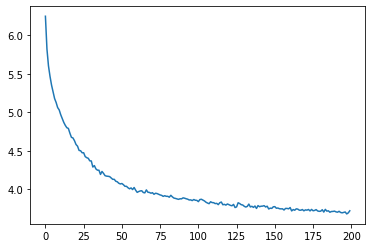

In [10]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_list)

# Text Generating

In [11]:
def generate(initial_str="A", predict_len=10000, sequence_length=1):
    model.eval()
    hidden, cell = model.init_state(1)
    
    initial_tensor = torch.zeros((1,sequence_length)).long()
    initial_tensor[0][0] = char2int[initial_str]

    predicted = initial_str

    last_char = initial_tensor

    for p in range(predict_len):
        output, (hidden, cell) = model(last_char.to(device), hidden, cell)
        topi = torch.argmax(output, dim=2)
        predicted_char = int2char[topi.item()]
        predicted += predicted_char
        
        last_char = torch.zeros((1, sequence_length)).long()
        last_char[0][0] = char2int[predicted_char]
        
    return predicted

generated_text = generate()

In [12]:
print(generated_text)

A q%8qâ?â”B”c100 j0 VC]â€”BB85â€”q”8qq”q”qqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqq